# Credit Card Fraud Detection Using Machine Learning

## Objective:
- Detect fraudulent credit card transactions using machine learning models while handling class imbalance effectively.

## Dataset:
The Kaggle Credit Card Transactions dataset, which contains transactions labeled as legitimate (0) or fraudulent (1). The dataset is highly imbalanced, with fraud cases representing a small fraction of all transactions.

## Approach:

1. Data Preprocessing:

- Feature-target separation and optional standardization.

- Handling missing values if any.

2. Handling Imbalance:

- Oversampling the minority class using SMOTE to generate synthetic fraud examples.

- Ensures models learn patterns from both classes effectively.

3. Modeling:

- Random Forest (RF)

- XGBoost (XGB)

- LightGBM (LGBM)

- Models are trained on the oversampled dataset and evaluated using classification metrics such as precision, recall, F1-score, and confusion matrix.

4. Experiment Tracking:

- MLflow is used to log parameters, metrics, and trained models for reproducibility and monitoring.

5. Inference:

- Trained models are saved and can be loaded later to predict fraud on new/unseen transactions.

## Goal:
Develop robust, reproducible models for fraud detection, ensuring high recall on fraud cases while maintaining acceptable performance on legitimate transactions.

# Model

## Importing Libraries

In [1]:
!pip install polars
!pip install mlflow
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.0/314.0 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.4/718.4 kB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.

In [2]:
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score
import shap
import mlflow
import mlflow.xgboost

## Basic Observations

In [4]:
# Load CSV
df = pl.read_csv(r"/content/credit_card_transactions.csv")

# View first rows
df.sample(5)

Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
i64,str,i64,str,str,f64,str,str,str,str,str,str,i64,f64,f64,i64,str,str,str,i64,f64,f64,i64,i64
69994,"""2019-02-11 05:52:25""",4708992452821239,"""fraud_Kilback LLC""","""grocery_pos""",104.83,"""Jared""","""Walters""","""M""","""3326 Hannah Fords""","""Cord""","""AR""",72524,35.8184,-91.3375,376,"""Designer, ceramics/pottery""","""1938-09-08""","""fc0595ad590c128c2c74ad2835ff57…",1328939545,36.663682,-91.260946,0,65690
68036,"""2019-02-10 07:00:38""",213178850083780,"""fraud_Labadie, Treutel and Bod…","""shopping_net""",96.04,"""Shawn""","""King""","""M""","""31493 Garcia Summit""","""Athena""","""OR""",97813,45.8289,-118.4971,1302,"""Dealer""","""1976-10-18""","""fc8171d8ff2dda20e8c19b0f190e3b…",1328857238,45.300252,-118.195631,0,97850
170080,"""2019-03-30 23:31:48""",30234966027947,"""fraud_Hagenes, Kohler and Hopp…","""food_dining""",32.79,"""Matthew""","""Lambert""","""M""","""7188 Melissa Crest Apt. 151""","""New Holstein""","""WI""",53061,43.9446,-88.0911,5196,"""Child psychotherapist""","""1978-01-22""","""6a31df38719497ed16b2c513778d9d…",1333150308,43.347865,-87.80731,0,53074
20666,"""2019-01-13 13:53:51""",4060579726528237,"""fraud_Medhurst Inc""","""home""",41.97,"""Steven""","""Sanders""","""M""","""25955 Amy Via""","""Ozawkie""","""KS""",66070,39.2136,-95.4404,2661,"""Theatre director""","""1948-11-14""","""a1ea43bc6755aeb8b45aef1b127db4…",1326462831,38.976962,-94.668036,0,66204
120108,"""2019-03-09 00:40:16""",3513285035244624,"""fraud_Grimes LLC""","""entertainment""",56.29,"""Ariana""","""Campbell""","""F""","""50932 Neal Valley""","""Daniels""","""WV""",25832,37.7256,-81.1087,3994,"""Biochemist, clinical""","""1936-11-05""","""67c03bb59c6548b27452b22ac6e17e…",1331253616,38.012523,-81.983349,0,25505


In [5]:
df.columns

['Unnamed: 0',
 'trans_date_trans_time',
 'cc_num',
 'merchant',
 'category',
 'amt',
 'first',
 'last',
 'gender',
 'street',
 'city',
 'state',
 'zip',
 'lat',
 'long',
 'city_pop',
 'job',
 'dob',
 'trans_num',
 'unix_time',
 'merch_lat',
 'merch_long',
 'is_fraud',
 'merch_zipcode']

- Unnamed: 0 – This is just an index column created when exporting the CSV; it doesn’t carry any information about the transaction.

- trans_date_trans_time – The exact date and time when the transaction occurred. This can be used to derive features like the hour of the day, day of the week, or month.

- cc_num – The credit card number used for the transaction. This is sensitive information and not used directly for modeling.

- merchant – The name of the merchant where the transaction took place. Different merchants may have different fraud risks.

- category – The type of transaction, such as entertainment, miscellaneous, or online purchases. This can help identify patterns in spending behavior.

- amt – The amount of money involved in the transaction. Larger amounts may have higher fraud risk.

- first – First name of the cardholder. Not relevant for modeling.

- last – Last name of the cardholder. Not relevant for modeling.

- gender – Gender of the cardholder (male or female). Can be used as a categorical feature.

- street – Street address of the cardholder. Usually not used directly for modeling.

- city – City of the cardholder. May help identify geographic patterns.

- state – State of the cardholder. Can be encoded to capture regional differences.

- zip – ZIP code of the cardholder. Can be used as a numeric or categorical feature.

- lat – Latitude of the cardholder’s location. Useful for detecting unusual transaction locations.

- long – Longitude of the cardholder’s location. Useful for detecting unusual transaction locations.

- city_pop – Population of the cardholder’s city. Could be correlated with fraud risk depending on urban vs rural behavior.

- job – Occupation of the cardholder. Certain job categories may be associated with different spending patterns.

- dob – Date of birth of the cardholder. Can be used to calculate age for modeling.

- trans_num – Unique identifier for each transaction. Not used as a feature.

- unix_time – The transaction time represented in UNIX timestamp format. Alternative to trans_date_trans_time.

- merch_lat – Latitude of the merchant location. Helps detect transactions occurring far from the cardholder’s usual area.

- merch_long – Longitude of the merchant location. Helps detect unusual transaction locations.

- is_fraud – Target variable: 1 indicates a fraudulent transaction, 0 indicates legitimate.

- merch_zipcode – ZIP code of the merchant. Can help capture geographic patterns in fraud.

In [6]:
df.shape

(173300, 24)

In [7]:
df.null_count()

Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,26274


Here, we can see that there is almost no null values in every features except "merch_zipcode" so we need to handle this.

In [8]:
# Compute unique counts per column
unique_counts = df.select([
    pl.col(col).n_unique().alias(col) for col in df.columns
])

# Convert to tidy format: feature → unique_count
unique_counts_tidy = unique_counts.transpose(
    include_header=True,  # keep column names
    header_name="feature",
    column_names=["unique_count"]
)

# Show all rows
print(unique_counts_tidy)


shape: (24, 2)
┌───────────────────────┬──────────────┐
│ feature               ┆ unique_count │
│ ---                   ┆ ---          │
│ str                   ┆ u32          │
╞═══════════════════════╪══════════════╡
│ Unnamed: 0            ┆ 173300       │
│ trans_date_trans_time ┆ 170996       │
│ cc_num                ┆ 930          │
│ merchant              ┆ 693          │
│ category              ┆ 14           │
│ …                     ┆ …            │
│ unix_time             ┆ 171028       │
│ merch_lat             ┆ 172415       │
│ merch_long            ┆ 172926       │
│ is_fraud              ┆ 3            │
│ merch_zipcode         ┆ 25165        │
└───────────────────────┴──────────────┘


## Feature Engineering

### DateTime
"trans_date_trans_time	" is converted into Datetime format

In [9]:
df = df.with_columns([
    pl.col("trans_date_trans_time")
      .str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S", strict=False)
      .alias("trans_date_trans_time")
])

### Season
Creating a new feature named "trans_day_cycle" which indicates the time of transcation in a cycle of day format. Here, the entries are "morning", "afternoon", "evening" and "night". This shows the time on the day when there is max fraud cases.

In [10]:
# Extract hour
df = df.with_columns([
    df["trans_date_trans_time"].dt.hour().alias("hour")
])

# Map to day cycle
def day_cycle(hour: int) -> str:
    if 5 <= hour < 12:
        return "morning"
    elif 12 <= hour < 17:
        return "afternoon"
    elif 17 <= hour < 21:
        return "evening"
    else:
        return "night"

df = df.with_columns([
    df["hour"].map_elements(day_cycle, return_dtype=pl.Utf8).alias("trans_day_cycle")
])


A new feature names "trans_season" is created from datetime to see the probability of fraud cases in each seasons.

In [11]:
df = df.with_columns([
    df["trans_date_trans_time"].dt.month().alias("month")
])

# Define mapping function
def get_season(month: int) -> str:
    if month in [12, 1, 2]:
        return "winter"
    elif month in [3, 4, 5]:
        return "spring"
    elif month in [6, 7, 8]:
        return "summer"
    else:
        return "autumn"

# Apply mapping
df = df.with_columns([
    df["month"].map_elements(get_season, return_dtype=pl.Utf8).alias("trans_season")
])

### Binning amount
The raw transaction amount (amt) is converted into a categorical feature named trans_amt_range, where amounts are grouped into small, medium, and large ranges. This transformation helps capture patterns in fraud likelihood based on transaction size. By binning continuous amounts into meaningful ranges, we make it easier to analyze whether fraudulent transactions are more common for larger amounts compared to smaller ones.

In [12]:
def amt_range(amt: float) -> str:
    if amt < 100:
        return "small"
    elif amt < 1000:
        return "medium"
    else:
        return "large"

df = df.with_columns([
    df["amt"].map_elements(amt_range, return_dtype=pl.Utf8).alias("trans_amt_range")
])

In [13]:
df.sample(5)

Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode,hour,trans_day_cycle,month,trans_season,trans_amt_range
i64,datetime[μs],i64,str,str,f64,str,str,str,str,str,str,i64,f64,f64,i64,str,str,str,i64,f64,f64,i64,i64,i8,str,i8,str,str
86709,2019-02-20 13:12:34,4208110975550360171,"""fraud_Kozey-McDermott""","""travel""",474.33,"""David""","""Bonilla""","""M""","""82073 Jessica Camp""","""West Green""","""GA""",31567,31.6143,-82.7243,782,"""Audiological scientist""","""1982-01-16""","""d31576410671271422b58451259a7b…",1329743554,32.179087,-82.539602,0,30410,13,"""afternoon""",2,"""winter""","""medium"""
139050,2019-03-17 05:02:06,6511349151405438,"""fraud_Gutmann-Upton""","""misc_pos""",8.82,"""Robert""","""Nguyen""","""M""","""74835 Garner Point""","""Ruth""","""NV""",89319,39.3426,-114.8859,450,"""Interpreter""","""1946-08-24""","""41c874557d58e5258a4393d245ff14…",1331960526,39.344446,-114.211675,0,null,5,"""morning""",3,"""spring""","""small"""
15306,2019-01-09 19:31:48,30011465039817,"""fraud_Rau-Robel""","""kids_pets""",48.72,"""Lisa""","""Garcia""","""F""","""213 Gill Expressway""","""Chatham""","""NY""",12037,42.3496,-73.5873,4015,"""Human resources officer""","""1971-10-14""","""10c75df9cb3d07647ff6996eddac34…",1326137508,41.852226,-74.558104,0,12740,19,"""evening""",1,"""winter""","""small"""
126738,2019-03-11 07:07:57,5359543825610251,"""fraud_Mosciski, Gislason and M…","""grocery_pos""",57.18,"""Michael""","""Francis""","""M""","""1833 Jeanette Stravenue""","""Belgrade""","""MT""",59714,45.7801,-111.1439,18182,"""Engineer, drilling""","""1975-06-29""","""f9536e79619767862b4eeccb409757…",1331449677,46.586134,-112.049716,0,59626,7,"""morning""",3,"""spring""","""small"""
132598,2019-03-14 07:34:07,60422928733,"""fraud_Koss, McLaughlin and May…","""food_dining""",69.18,"""Jeffrey""","""Powers""","""M""","""38352 Parrish Road Apt. 652""","""North Augusta""","""SC""",29860,33.6028,-81.9748,46944,"""Secondary school teacher""","""1942-04-02""","""d0e8f2d9fe7b45c8ef5413ce14c4ad…",1331710447,33.997975,-82.543945,0,29840,7,"""morning""",3,"""spring""","""small"""


### Age during transcation
Why create age_during_trans and age_group:

- To understand how the age of a person at the time of a transaction relates to the likelihood of fraud.

- Categorizing ages helps identify patterns in fraud across different age groups.

In [14]:
# Cast trans_date_trans_time to Date (if not already)
df = df.with_columns([
    pl.col("trans_date_trans_time").cast(pl.Date).alias("trans_date")
])

# Ensure dob is Date
df = df.with_columns([
    pl.col("dob").str.strptime(pl.Date, "%Y-%m-%d", strict=False).alias("dob")
])

# Calculate age during transaction
df = df.with_columns([
    ((pl.col("trans_date") - pl.col("dob")) / pl.duration(days=1) / 365.25)
    .floor()
    .cast(pl.Int32)
    .alias("age_during_trans")
])

# Create age group
df = df.with_columns([
    pl.when(pl.col("age_during_trans") < 30)
      .then(pl.lit("young"))
      .when(pl.col("age_during_trans").is_between(30, 60))
      .then(pl.lit("middle-aged"))
      .otherwise(pl.lit("senior"))
      .alias("age_group")
])

In [15]:
df.sample(5)

Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode,hour,trans_day_cycle,month,trans_season,trans_amt_range,trans_date,age_during_trans,age_group
i64,datetime[μs],i64,str,str,f64,str,str,str,str,str,str,i64,f64,f64,i64,str,date,str,i64,f64,f64,i64,i64,i8,str,i8,str,str,date,i32,str
106001,2019-03-02 17:34:58,4997733566924489,"""fraud_Beier and Sons""","""home""",3.44,"""Stephanie""","""Taylor""","""F""","""598 Martin Pine Suite 365""","""Saint Paul""","""MN""",55128,44.9913,-92.9487,753116,"""Fisheries officer""",1971-08-06,"""b1c4983decfbd7cd78e0c1b69b801a…",1330709698,45.410233,-93.125388,0,55005,17,"""evening""",3,"""spring""","""small""",2019-03-02,47,"""middle-aged"""
152263,2019-03-23 07:26:41,4642894980163,"""fraud_Wolf Inc""","""grocery_pos""",38.37,"""Eddie""","""Mendez""","""M""","""1831 Faith View Suite 653""","""Clarinda""","""IA""",51632,40.7491,-95.038,7297,"""IT trainer""",1990-07-13,"""e7f9158f1ea88249223a01c74ff11c…",1332487601,41.516612,-95.198695,0,51577,7,"""morning""",3,"""spring""","""small""",2019-03-23,28,"""young"""
86094,2019-02-19 23:13:31,3504178999463051,"""fraud_Schoen, Nienow and Bauch""","""personal_care""",105.38,"""Drew""","""Garcia""","""M""","""70858 Jasmine Meadows Apt. 135""","""Lima""","""OH""",45801,40.7641,-84.0973,86954,"""Copywriter, advertising""",1992-07-23,"""f47686dfc77276a1146562cdea899b…",1329693211,41.501083,-84.322118,0,43502,23,"""night""",2,"""winter""","""medium""",2019-02-19,26,"""young"""
21189,2019-01-13 18:55:54,4997733566924489,"""fraud_Kozey-Boehm""","""shopping_net""",534.82,"""Stephanie""","""Taylor""","""F""","""598 Martin Pine Suite 365""","""Saint Paul""","""MN""",55128,44.9913,-92.9487,753116,"""Fisheries officer""",1971-08-06,"""ccca258eb2efb3c053fae715dbf7c7…",1326480954,45.505,-92.812799,0,55056,18,"""evening""",1,"""winter""","""medium""",2019-01-13,47,"""middle-aged"""
52382,2019-01-31 22:01:04,6011626928491360,"""fraud_Weber, Thiel and Hammes""","""kids_pets""",41.7,"""Heather""","""Roberts""","""F""","""62934 Maria Cliffs Suite 350""","""Bethel Springs""","""TN""",38315,35.2289,-88.644,3876,"""Senior tax professional/tax in…",1960-11-19,"""a8b102286bb379f3da34f4d7fe3311…",1328047264,34.254958,-88.069641,0,35593,22,"""night""",1,"""winter""","""small""",2019-01-31,58,"""middle-aged"""


In [16]:
df['merchant'].unique()

merchant
str
"""fraud_Daugherty LLC"""
"""fraud_Johns-Hoeger"""
"""fraud_Bins, Balistreri and Bea…"
"""fraud_Dicki Ltd"""
"""fraud_Stark-Batz"""
…
"""fraud_Effertz LLC"""
"""fraud_Schimmel-Olson"""
"""fraud_Gislason Group"""


In [17]:
df['category'].unique()

category
str
"""kids_pets"""
"""gas_transport"""
"""entertainment"""
"""health_fitness"""
"""misc_pos"""
…
"""misc_net"""
"""grocery_pos"""
"""food_dining"""


In [18]:
df['job'].unique()

job
str
"""Press sub"""
"""Archaeologist"""
"""Engineer, civil (contracting)"""
"""Cartographer"""
"""Engineer, broadcasting (operat…"
…
"""Make"""
"""Manufacturing systems engineer"""
"""Naval architect"""


In [19]:
df['city'].unique()

city
str
"""Belmond"""
"""New Franken"""
"""Wheaton"""
"""Ehrhardt"""
"""Eugene"""
…
"""North Judson"""
"""Providence"""
"""High Rolls Mountain Park"""


In [20]:
df['state'].unique()

state
str
"""ND"""
"""ME"""
"""SD"""
"""LA"""
"""IL"""
…
"""CT"""
"""RI"""
"""KY"""


In [21]:
df.columns

['Unnamed: 0',
 'trans_date_trans_time',
 'cc_num',
 'merchant',
 'category',
 'amt',
 'first',
 'last',
 'gender',
 'street',
 'city',
 'state',
 'zip',
 'lat',
 'long',
 'city_pop',
 'job',
 'dob',
 'trans_num',
 'unix_time',
 'merch_lat',
 'merch_long',
 'is_fraud',
 'merch_zipcode',
 'hour',
 'trans_day_cycle',
 'month',
 'trans_season',
 'trans_amt_range',
 'trans_date',
 'age_during_trans',
 'age_group']

### Dropping Identifiers

In [22]:
# Convert Polars DataFrame to Pandas (XGBoost needs pandas/numpy)
df_pd = df.to_pandas()

# Drop identifier-like columns (they don’t help in prediction)
drop_cols = [
    "Unnamed: 0", "trans_date_trans_time", "cc_num", "merchant", "first", "last", "street", "city",
    "dob", "trans_num", "unix_time", "merch_zipcode", "trans_date"
]
df_pd = df_pd.drop(columns=drop_cols, errors="ignore")

In [23]:
df_pd.sample(5)

,category,amt,gender,state,zip,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,hour,trans_day_cycle,month,trans_season,trans_amt_range,age_during_trans,age_group
34515,shopping_pos,170.30,M,MN,56019.0,44.1111,-94.9134,914.0,Health and safety adviser,44.894553,-94.674318,0.0,11,morning,1,winter,medium,74.0,senior
1593,kids_pets,89.61,M,ME,4047.0,43.7450,-70.9092,1892.0,Audiological scientist,43.141288,-70.871510,0.0,17,evening,1,winter,small,62.0,senior
3844,gas_transport,60.41,F,TX,77412.0,29.6047,-96.5249,106.0,"Editor, film/video",30.286831,-96.272422,0.0,8,morning,1,winter,small,35.0,middle-aged
1931,kids_pets,2.72,F,IN,46254.0,39.8490,-86.2720,910148.0,Firefighter,39.795803,-86.393588,0.0,19,evening,1,winter,small,43.0,middle-aged
56063,grocery_net,45.96,F,VA,22810.0,38.8089,-78.7776,863.0,"Engineer, mining",39.660291,-79.046739,0.0,8,morning,2,winter,small,46.0,middle-aged


In [24]:
df_pd.isnull().sum()

,0
category,0
amt,0
gender,0
state,0
zip,1
lat,1
long,1
city_pop,1
job,1
merch_lat,1


In [25]:
df_pd.dropna(inplace = True)
df_pd.isnull().sum()

,0
category,0
amt,0
gender,0
state,0
zip,0
lat,0
long,0
city_pop,0
job,0
merch_lat,0


## Train test split with OneHot encoding

In [26]:
# Separate features and target
X = df_pd.drop(columns=["is_fraud"])
y = df_pd["is_fraud"]

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)

# Train/test split (80% train, 20% test, keep class ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [41]:
X.sample(5)

,amt,zip,lat,long,city_pop,merch_lat,merch_long,hour,month,age_during_trans,...,job_Wellsite geologist,job_Writer,trans_day_cycle_evening,trans_day_cycle_morning,trans_day_cycle_night,trans_season_winter,trans_amt_range_medium,trans_amt_range_small,age_group_senior,age_group_young
81246,9.33,33710.0,27.7898,-82.7243,341043.0,28.201978,-82.616451,21,2,29.0,...,False,False,False,False,True,True,False,True,False,True
95659,8.93,59542.0,48.8328,-108.3961,192.0,48.877181,-107.531845,22,2,55.0,...,False,False,False,False,True,True,False,True,False,False
6739,47.01,72042.0,34.2853,-91.3336,5161.0,33.713930,-91.212579,10,1,25.0,...,False,False,False,True,False,True,False,True,False,True
48341,212.37,41810.0,37.1788,-82.6950,502.0,38.120463,-83.535574,6,1,58.0,...,False,False,False,True,False,True,True,False,False,False
32937,53.17,61830.0,39.9972,-88.6962,478.0,39.620885,-89.213323,16,1,59.0,...,False,False,False,False,False,True,False,True,False,False


In [31]:
# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(
    n_estimators=300,       # number of trees
    max_depth=6,            # tree depth
    learning_rate=0.1,      # step size for boosting
    subsample=0.8,          # 80% of rows per tree
    colsample_bytree=0.8,   # 80% of features per tree
    random_state=42,
    scale_pos_weight=(len(y[y==0]) / len(y[y==1]))  # handle imbalance
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

# Evaluation
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     34357
         1.0       0.75      0.93      0.83       303

    accuracy                           1.00     34660
   macro avg       0.87      0.97      0.91     34660
weighted avg       1.00      1.00      1.00     34660

ROC-AUC: 0.9985646729530188


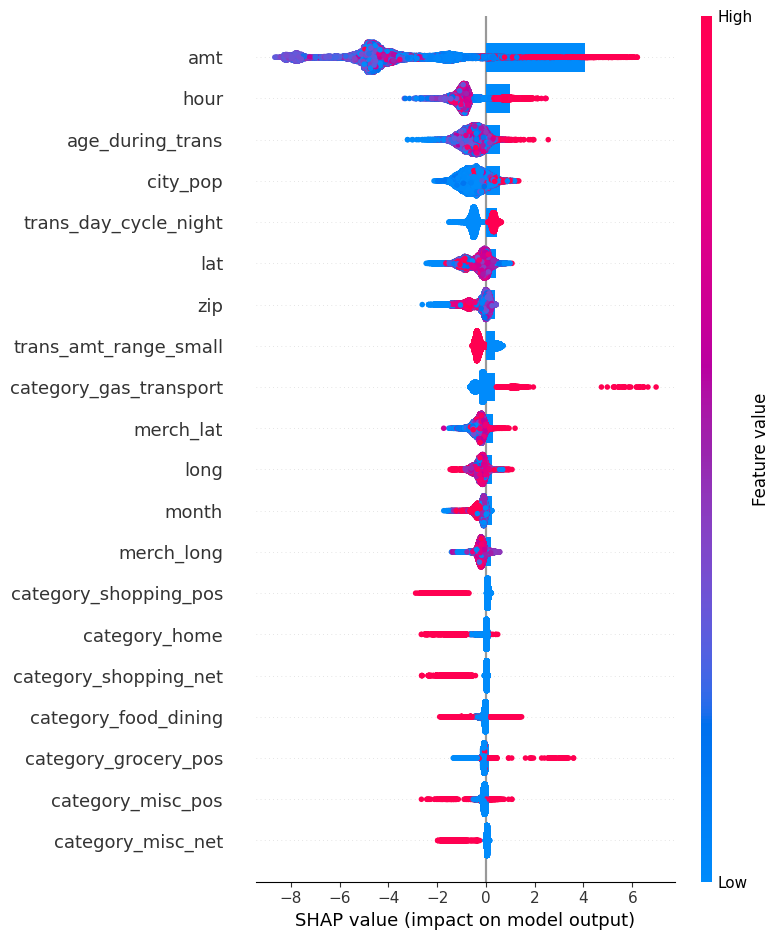

In [32]:
# Initialize SHAP explainer
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

# Global feature importance (summary plot - bar)
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig("shap_summary_bar.png")

# Global feature importance (beeswarm - shows distribution)
shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()
plt.savefig("shap_summary_beeswarm.png")

In [33]:
with mlflow.start_run(run_name="XGBoost_SHAP_FraudDetection"):

    # Log metric
    mlflow.log_metric("roc_auc", roc_auc_score(y_test, y_prob))

    # Compute mean absolute SHAP importance for each feature
    shap_importance = pd.DataFrame({
        "feature": X_test.columns,
        "importance": abs(shap_values.values).mean(axis=0)
    }).sort_values(by="importance", ascending=False)

    # Log top 10 features as parameter
    mlflow.log_param("top_features", shap_importance.head(10)["feature"].tolist())

    # Log SHAP plots
    mlflow.log_artifact("shap_summary_bar.png")
    mlflow.log_artifact("shap_summary_beeswarm.png")

    # Log model
    mlflow.xgboost.log_model(xgb_model, "xgb_model")

print("✅ Training, SHAP, and MLflow logging complete.")

2025/09/26 05:38:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:1028: UserWarning: [05:38:17] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/09/26 05:38:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Training, SHAP, and MLflow logging complete.
